#The Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import metrics

#Data Importing

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
satellite = pd.read_csv('/content/drive/MyDrive/445ml/jan_train_50k.csv')

#Dataset Information

In [4]:
#check unique values
satellite.apply(lambda x: len(x.unique()))

id        49999
epoch     27204
sat_id       60
x         49999
y         49999
z         49999
Vx        49998
Vy        49999
Vz        49998
x_sim     49999
y_sim     49999
z_sim     49999
Vx_sim    49999
Vy_sim    49999
Vz_sim    49999
dtype: int64

In [5]:
satellite.head()

id    epoch  sat_id             x  ...        z_sim    Vx_sim    Vy_sim    Vz_sim
0   0  00:00.0       0  -8855.823863  ... -20741.61531 -0.907527 -3.804930 -2.024133
1   1  46:43.0       0 -10567.672380  ... -24473.08956 -0.303704 -4.269816 -0.616468
2   2  33:26.0       0 -10578.684040  ... -24271.16978  0.274880 -4.046788  0.718768
3   3  20:09.0       0  -9148.251857  ... -20765.01909  0.712437 -3.375202  1.718306
4   4  06:52.0       0  -6719.092336  ... -14992.39999  0.989382 -2.522618  2.342237

[5 rows x 15 columns]

In [6]:
#info about datatype
satellite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      49999 non-null  int64  
 1   epoch   49999 non-null  object 
 2   sat_id  49999 non-null  int64  
 3   x       49999 non-null  float64
 4   y       49999 non-null  float64
 5   z       49999 non-null  float64
 6   Vx      49999 non-null  float64
 7   Vy      49999 non-null  float64
 8   Vz      49999 non-null  float64
 9   x_sim   49999 non-null  float64
 10  y_sim   49999 non-null  float64
 11  z_sim   49999 non-null  float64
 12  Vx_sim  49999 non-null  float64
 13  Vy_sim  49999 non-null  float64
 14  Vz_sim  49999 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 5.7+ MB


#Checking Missing / Null Values

In [7]:
#missing values
satellite.isnull().sum()

id        0
epoch     0
sat_id    0
x         0
y         0
z         0
Vx        0
Vy        0
Vz        0
x_sim     0
y_sim     0
z_sim     0
Vx_sim    0
Vy_sim    0
Vz_sim    0
dtype: int64

#Dataset Visualization

In [8]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [9]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [10]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [11]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# jan_train_50k.csv have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/drive/MyDrive/445ml/jan_train_50k.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'jan_train_50k.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 15 columns


**Column Distribution**

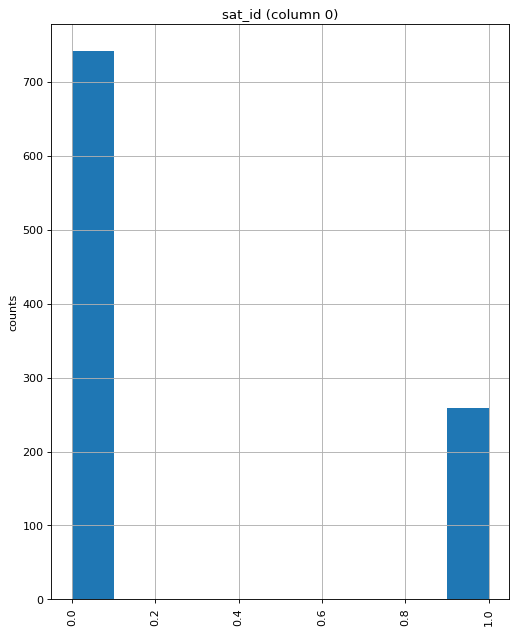

In [12]:
plotPerColumnDistribution(df1, 10, 5)


**Correlation Matrix**

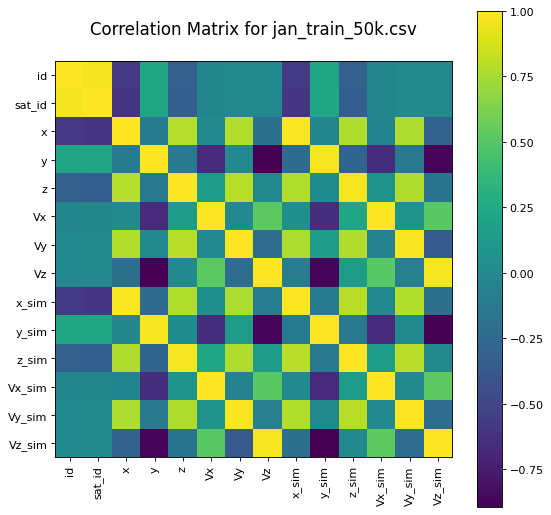

In [13]:
plotCorrelationMatrix(df1, 8)

**Scatter Matrix**

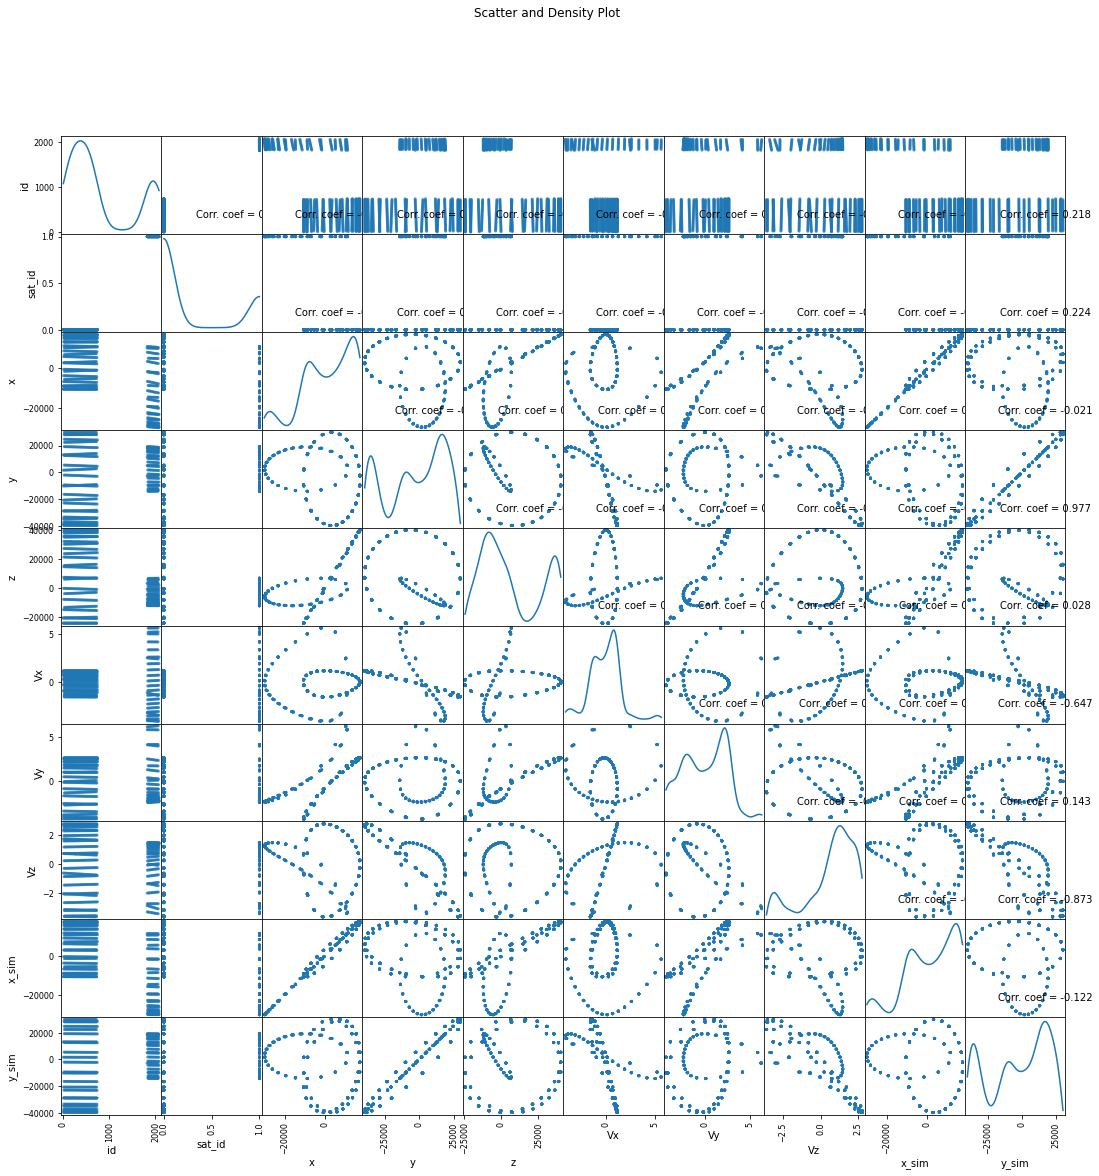

In [14]:
plotScatterMatrix(df1, 18, 10)

#Feature Reduction

In [15]:
print(satellite.shape)

(49999, 15)


In [16]:
data=satellite.drop(columns = ['id', 'epoch'])
data.head()

sat_id             x             y  ...    Vx_sim    Vy_sim    Vz_sim
0       0  -8855.823863  13117.780150  ... -0.907527 -3.804930 -2.024133
1       0 -10567.672380   1619.746066  ... -0.303704 -4.269816 -0.616468
2       0 -10578.684040 -10180.467460  ...  0.274880 -4.046788  0.718768
3       0  -9148.251857 -20651.437460  ...  0.712437 -3.375202  1.718306
4       0  -6719.092336 -28929.061630  ...  0.989382 -2.522618  2.342237

[5 rows x 13 columns]

In [17]:
print(data.shape)

(49999, 13)


In [18]:
data.values

array([[ 0.00000000e+00, -8.85582386e+03,  1.31177802e+04, ...,
        -9.07526561e-01, -3.80492982e+00, -2.02413344e+00],
       [ 0.00000000e+00, -1.05676724e+04,  1.61974607e+03, ...,
        -3.03703719e-01, -4.26981610e+00, -6.16468474e-01],
       [ 0.00000000e+00, -1.05786840e+04, -1.01804675e+04, ...,
         2.74880377e-01, -4.04678761e+00,  7.18768459e-01],
       ...,
       [ 5.90000000e+01, -9.24178631e+03,  7.28264508e+03, ...,
        -5.75669969e-01, -3.79938494e+00,  1.47850919e+00],
       [ 5.90000000e+01, -1.10031537e+04,  3.46967917e+03, ...,
         4.32396470e-02, -3.56485195e+00,  2.20298609e+00],
       [ 5.90000000e+01, -1.22502335e+04, -5.05203477e+02, ...,
         6.95399630e-01, -3.12983788e+00,  2.85341359e+00]])

#Feature Splitting

In [19]:
data.columns

Index(['sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim', 'z_sim',
       'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [20]:
x = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']]

In [21]:
y = data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

In [22]:
data = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']]

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       49999 non-null  float64
 1   y       49999 non-null  float64
 2   z       49999 non-null  float64
 3   Vx      49999 non-null  float64
 4   Vy      49999 non-null  float64
 5   Vz      49999 non-null  float64
 6   x_sim   49999 non-null  float64
 7   y_sim   49999 non-null  float64
 8   z_sim   49999 non-null  float64
 9   Vx_sim  49999 non-null  float64
 10  Vy_sim  49999 non-null  float64
 11  Vz_sim  49999 non-null  float64
dtypes: float64(12)
memory usage: 4.6 MB


In [24]:
print(x)

                  x             y            z        Vx        Vy        Vz
0      -8855.823863  13117.780150 -20728.35323 -0.908303 -3.808436 -2.022083
1     -10567.672380   1619.746066 -24451.81327 -0.302590 -4.272617 -0.612796
2     -10578.684040 -10180.467460 -24238.28095  0.277435 -4.047522  0.723155
3      -9148.251857 -20651.437460 -20720.38128  0.715600 -3.373762  1.722115
4      -6719.092336 -28929.061630 -14938.90797  0.992507 -2.519732  2.344703
...             ...           ...          ...       ...       ...       ...
49994  -4517.431749  13710.801650 -14552.60073 -2.564393 -2.544990 -2.055544
49995  -7047.834585  10754.254420 -16313.23675 -2.291754 -3.123031 -1.326900
49996  -9241.786313   7282.645079 -17293.85972 -1.918957 -3.536291 -0.557258
49997 -11003.153660   3469.679165 -17464.46706 -1.460783 -3.779671  0.229643
49998 -12250.233540   -505.203477 -16818.68792 -0.930453 -3.847014  1.011607

[49999 rows x 6 columns]


In [25]:
print(y)

              x_sim         y_sim        z_sim    Vx_sim    Vy_sim    Vz_sim
0      -8843.131454  13138.221690 -20741.61531 -0.907527 -3.804930 -2.024133
1     -10555.500070   1649.289367 -24473.08956 -0.303704 -4.269816 -0.616468
2     -10571.858470 -10145.939910 -24271.16978  0.274880 -4.046788  0.718768
3      -9149.620794 -20618.200200 -20765.01909  0.712437 -3.375202  1.718306
4      -6729.358857 -28902.271440 -14992.39999  0.989382 -2.522618  2.342237
...             ...           ...          ...       ...       ...       ...
49994 -10370.381100   4979.032666 -17487.57066 -1.648422 -3.707079 -0.077099
49995 -11826.292840   1043.742566 -17158.28441 -1.144207 -3.843734  0.710133
49996 -12724.159680  -2940.167648 -16019.36755 -0.575670 -3.799385  1.478509
49997 -13004.268690  -6780.140154 -14103.08641  0.043240 -3.564852  2.202986
49998 -12622.823290 -10273.393050 -11470.13472  0.695400 -3.129838  2.853414

[49999 rows x 6 columns]


#Pair Plot of Processed Dataset

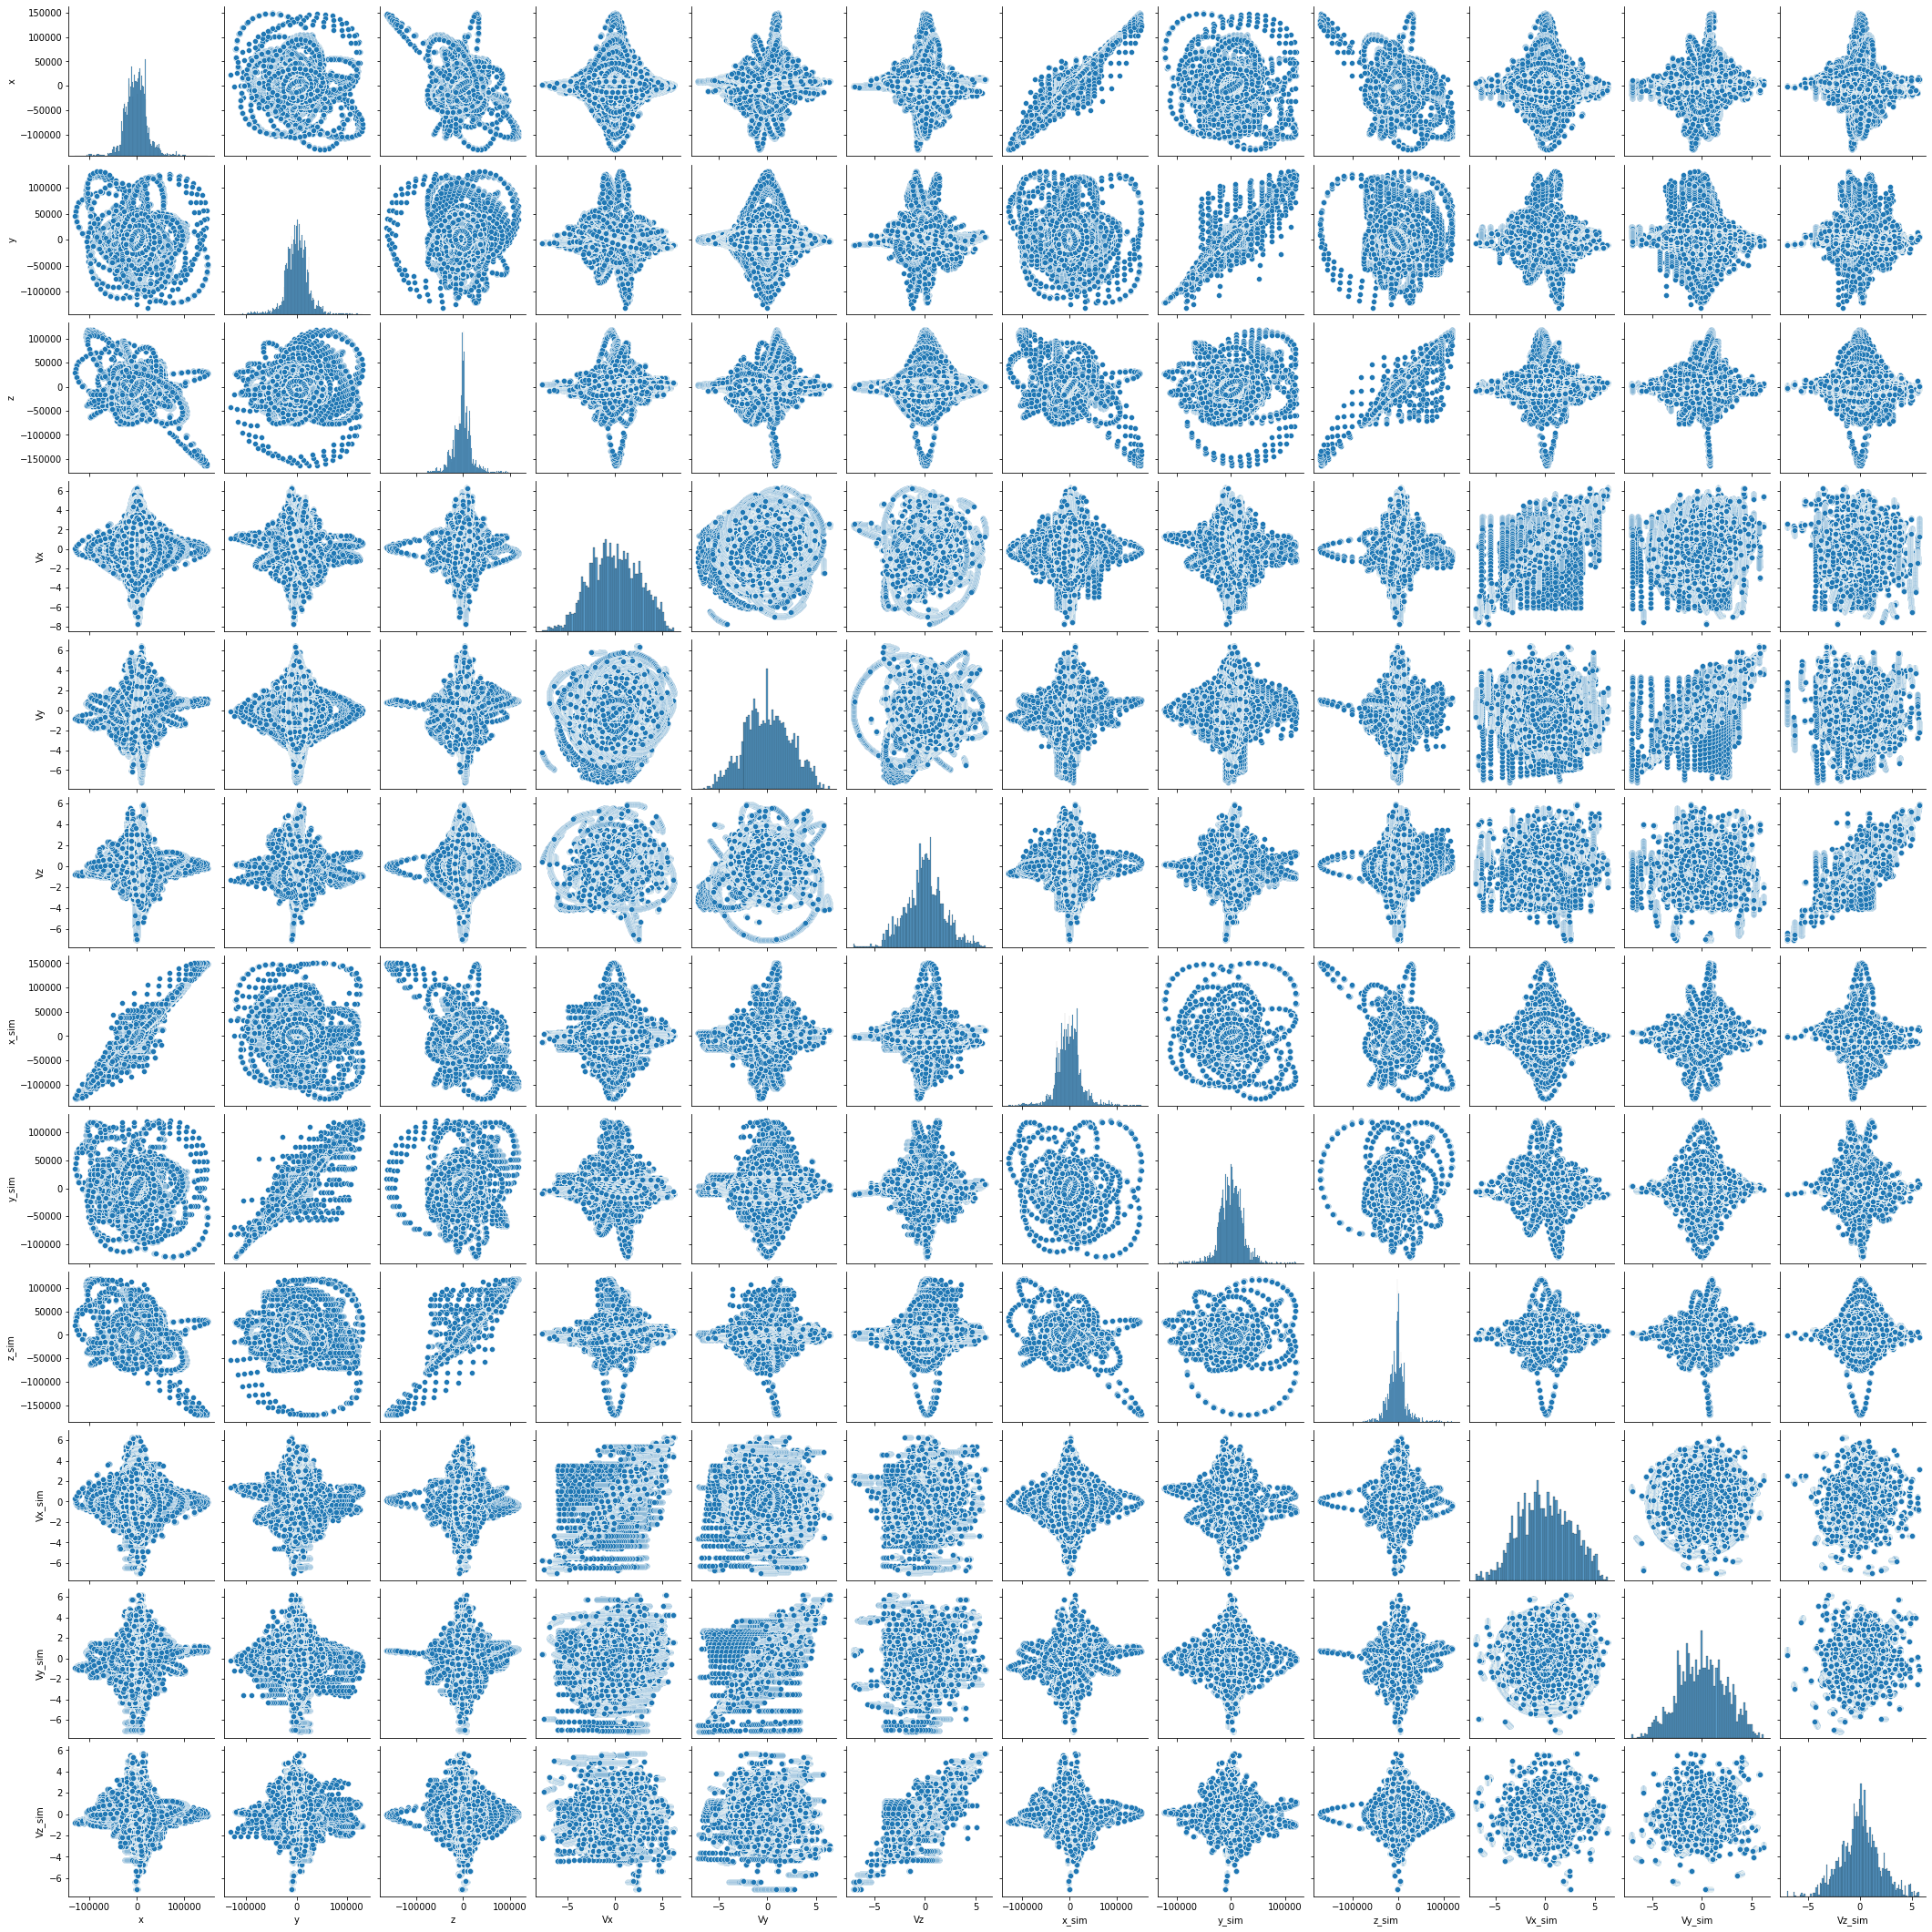

In [26]:
#pairplot
sns.pairplot(data)

#Splitting features into train and test sets

In [27]:
# split into train test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(33499, 6) (16500, 6) (33499, 6) (16500, 6)


#Model Building

In [28]:
def train (model, x_train, y_train):
  model.fit(x_train, y_train)
  predictions = model.predict(x_test)
  print("Accuracy: ",model.score(y_test, predictions)*100)
  print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(y_test, predictions)))
  print("MAE:",metrics.mean_absolute_error(y_test, predictions))
  print("MSE:",metrics.mean_squared_error(y_test, predictions))

**Linear Regression**

In [29]:
model = LinearRegression(normalize=True)
print("Model Report: Linear Regression")
train(model, x_train, y_train)

Model Report: Linear Regression
Accuracy:  92.35676180319695
RMSE : 4519
MAE: 1447.434763983151
MSE: 20422207.93112356


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


**Model Testing**

In [30]:
predictions = model.predict(x_test)

**Scatterplot Visualization**

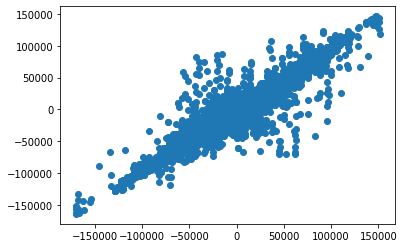

In [31]:
plt.scatter(y_test, predictions)

**Histogram**

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-125598.58711643,  -99756.56662113,  -73914.54612583,
         -48072.52563053,  -22230.50513523,    3611.51536007,
          29453.53585537,   55295.55635067,   81137.57684597,
         106979.59734127,  132821.61783658]),
 <a list of 16500 Lists of Patches objects>)

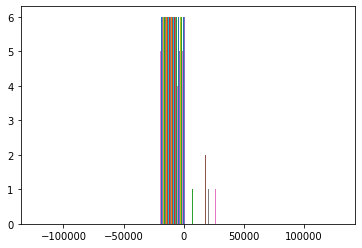

In [32]:
plt.hist(y_test - predictions)

**Ridge Regression Model**

In [33]:
model = Ridge(normalize=True)
print("Model Report: Ridge")
train(model, x_train, y_train)

Model Report: Ridge
Accuracy:  92.3470252312603
RMSE : 9281
MAE: 4554.033570437991
MSE: 86142066.37561984


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


**Lasso Regression Model**

In [34]:
model = Lasso()
print("Model Report: Lasso")
train(model, x_train, y_train)

Model Report: Lasso
Accuracy:  92.35671624773222
RMSE : 4519
MAE: 1447.4595838833745
MSE: 20422178.77249687


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


**Decision Tree**

In [35]:
# Fitting Decision Tree Regression to the dataset
model = DecisionTreeRegressor()
print("Model Report: Decision Tree")
train(model, x_train, y_train)

Model Report: Decision Tree
Accuracy:  95.63033165250775
RMSE : 2445
MAE: 293.56605146312626
MSE: 5980363.035756937


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


**Random Forest**

In [36]:
# fit the model
model = RandomForestRegressor()
print("Model Report: Random Forest")
train(model, x_train, y_train)

Model Report: Random Forest
Accuracy:  97.25361450797449
RMSE : 1980
MAE: 293.0563413274378
MSE: 3921095.402793294


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
